In [2]:
from darts.datasets import AustralianTourismDataset
from functools import reduce
from itertools import product
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
import matplotlib.pyplot as plt
from darts.metrics.metrics import mae
import numpy as np
import pandas as pd
from darts.dataprocessing.transformers.reconciliation import MinTReconciliator

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/user/virtualenvs/lh_desafio_ds_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tourism_series = AustralianTourismDataset().load()
tourism_series

<TimeSeries (DataArray) (time: 36, component: 96, sample: 1)> Size: 28kB
array([[[84503.],
        [45906.],
        [26042.],
        ...,
        [ 6841.],
        [ 3775.],
        [  483.]],

       [[65312.],
        [29347.],
        [20676.],
        ...,
        [ 6119.],
        [ 2091.],
        [ 1431.]],

       [[72753.],
        [32492.],
        [20582.],
        ...,
...
        ...,
        [ 6987.],
        [ 2788.],
        [ 1356.]],

       [[65938.],
        [30938.],
        [19751.],
        ...,
        [ 7669.],
        [ 1433.],
        [ 2685.]],

       [[69544.],
        [31845.],
        [22758.],
        ...,
        [ 7941.],
        [ 1603.],
        [ 1765.]]])
Coordinates:
  * time       (time) int64 288B 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * component  (component) object 768B 'Total' 'Hol' 'VFR' ... 'WA' 'TAS' 'NT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

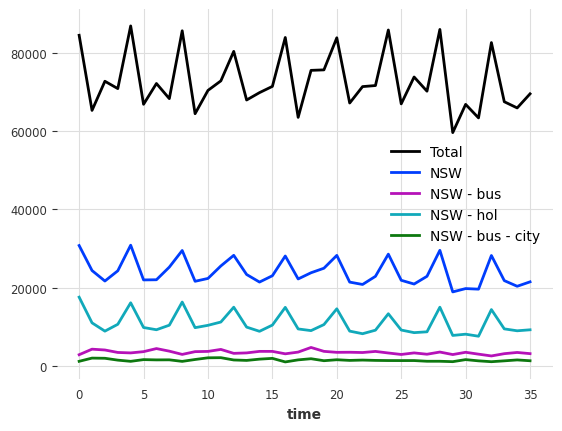

In [4]:
tourism_series[["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]].plot()


<Axes: xlabel='time'>

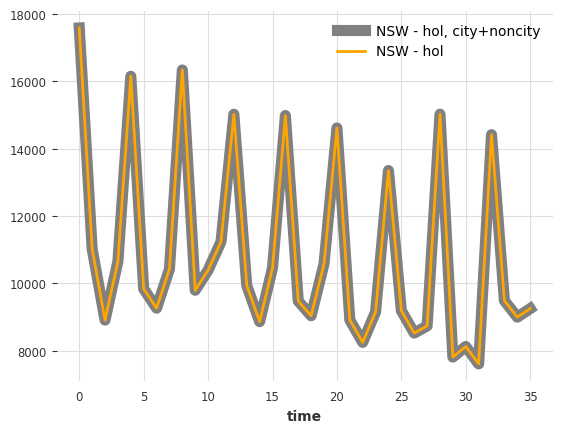

In [5]:
sum_city_noncity = (
    tourism_series["NSW - hol - city"] + tourism_series["NSW - hol - noncity"]
)
sum_city_noncity.plot(label="NSW - hol, city+noncity", lw=8, color="grey")
tourism_series["NSW - hol"].plot(color="orange")

<Axes: xlabel='time'>

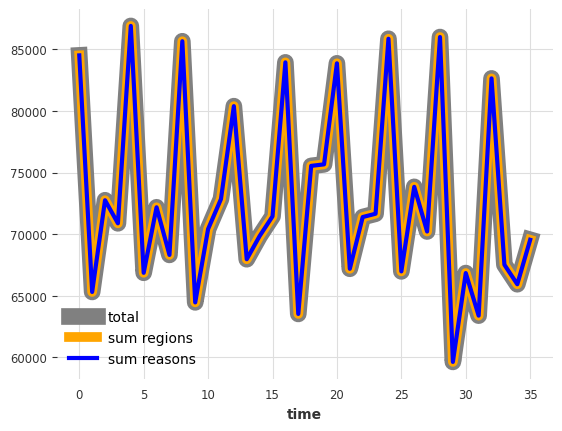

In [6]:
reasons = ["Hol", "VFR", "Bus", "Oth"]
regions = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]
city_labels = ["city", "noncity"]

tourism_series["Total"].plot(label="total", lw=12, color="grey")
sum([tourism_series[region] for region in regions]).plot(
    label="sum regions", lw=7, color="orange"
)
sum([tourism_series[reason] for reason in reasons]).plot(
    label="sum reasons", lw=3, color="blue"
)

In [21]:
# tourism_series

In [7]:
hierarchy = dict()

# Fill in grouping by reason
for reason in reasons:
    hierarchy[reason] = ["Total"]

# Fill in grouping by region
for region in regions:
    hierarchy[region] = ["Total"]

# Fill in grouping by (region, reason)
for region, reason in product(regions, reasons):
    hierarchy["{} - {}".format(region, reason.lower())] = [reason, region]

# Fill in grouping by (region, reason, <city>)
for region, reason, city in product(regions, reasons, city_labels):
    hierarchy["{} - {} - {}".format(region, reason.lower(), city)] = [
        "{} - {}".format(region, reason.lower())
    ]

In [8]:
for component in ["Hol", "NSW - hol", "NSW - bus - city"]:
    print(f"{component} -> {hierarchy[component]}")

Hol -> ['Total']
NSW - hol -> ['Hol', 'NSW']
NSW - bus - city -> ['NSW - bus']


In [20]:
# hierarchy

In [10]:
tourism_series = tourism_series.with_hierarchy(hierarchy)

In [11]:
train, val = tourism_series[:-12], tourism_series[-12:]

In [12]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

<Axes: xlabel='time'>

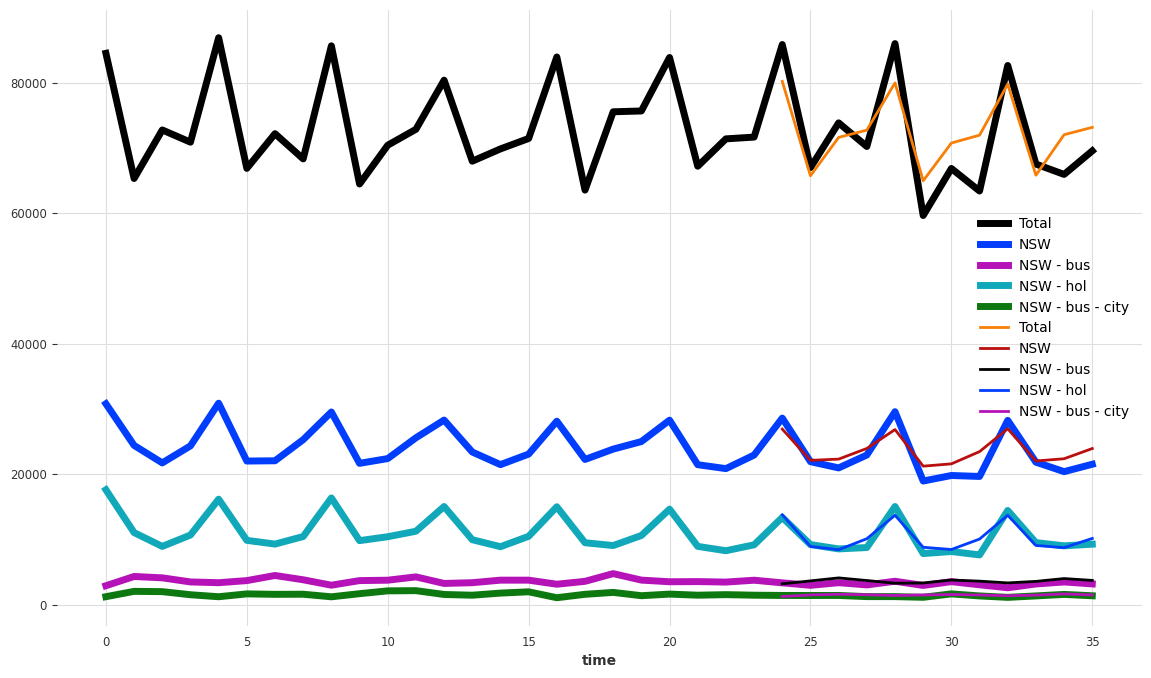

In [13]:
components_to_show = ["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]
plt.figure(figsize=(14, 8))
tourism_series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

In [14]:
# we pre-generate some of the components' names
regions_reasons_comps = list(
    map(lambda t: "{} - {}".format(t[0], t[1].lower()), product(regions, reasons))
)

regions_reasons_city_comps = list(
    map(
        lambda t: "{} - {} - {}".format(t[0], t[1].lower(), t[2]),
        product(regions, reasons, city_labels),
    )
)


def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        mae_val = np.mean(mae([pred[c] for c in subset], [val[c] for c in subset]))
        print(f"mean MAE on {name}: {mae_val:.2f}")

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")


measure_mae(pred)

mean MAE on total: 4142.62
mean MAE on reasons: 1284.79
mean MAE on regions: 805.20
mean MAE on (region, reason): 313.04
mean MAE on (region, reason, city): 190.68


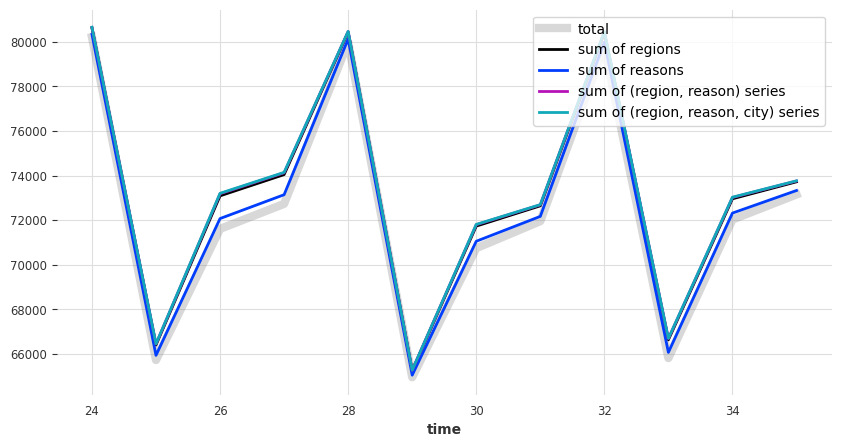

In [15]:
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 5))

    pred_series["Total"].plot(label="total", lw=6, alpha=0.3, color="grey")
    sum([pred_series[r] for r in regions]).plot(label="sum of regions")
    sum([pred_series[r] for r in reasons]).plot(label="sum of reasons")
    sum([pred_series[t] for t in regions_reasons_comps]).plot(
        label="sum of (region, reason) series"
    )
    sum([pred_series[t] for t in regions_reasons_city_comps]).plot(
        label="sum of (region, reason, city) series"
    )

    legend = plt.legend(loc="best", frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")


plot_forecast_sums(pred)

In [16]:
reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)

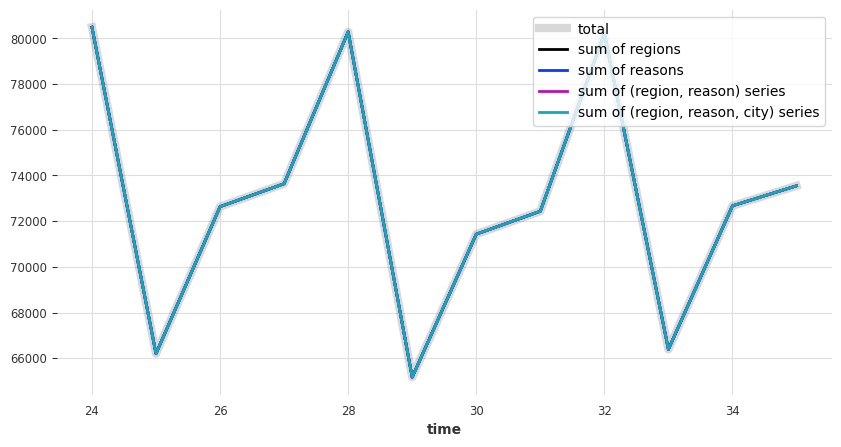

In [17]:
plot_forecast_sums(reconcilied_preds)

In [18]:
measure_mae(reconcilied_preds)

mean MAE on total: 4161.05
mean MAE on reasons: 1294.35
mean MAE on regions: 789.98
mean MAE on (region, reason): 309.63
mean MAE on (region, reason, city): 189.80
